In [1]:
from __future__ import division
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import math


In [2]:
fontSize=16
#matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'font.family':'MathJax_SansSerif', 'font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,'text.usetex':False,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'pdf.fonttype':42,'font.family':'DejaVu Sans','font.sans-serif':'Helvetica','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,'text.usetex':False,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
plotStyles={"markersize":8,"markeredgewidth":1.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
barStyles={"width":0.65, "linewidth":0, "align":"center"}

/Users/turtle/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [3]:
ktx1_RM = 0.205; alpha_RM = 5; 
ktx1_RE = 1.04; ktr1 = 0.887; 
ktx2 = 2.54; ktr2 = 0.919; 
ktx3 = 5.29; ktr3 = 1.10; 
klamb = 0.131; 
kd = 1/50;  #0.25
km1 = 0.1; kP1 = 3.22e-9; 
km2 = 0.158; kP2 = 1.33e-9;
km3 = 0.1; kP3 = 0.369; 

n_a_RM_cI = 2; n_r_RM_cI = 6;
n_RM_cro = 3; n_RE = 5; 
n_cro_cI = 2.55; n_cro_cro = 2.22; 
n_cII_cI = 3.95; n_cII_cro = 3;
n_lamb_cI = 6; n_lamb_cro = 6;
n_cII = 1; 

K_a_RM_cI = 108; K_r_RM_cI = 528; K_RM_cro = 20.4; 
K_RE = 78.1; 
K_cro_cI = 64.1; K_cro_cro = 94.2;
K_cII_cI = 64.1; K_cII_cro = 94.2; 
K_lamb_cI = 241; K_lamb_cro = 500;
K_cII = 241; 

tau_lamb = 7.5; 

In [4]:
def f_cI_RE(cII): #p_RE activation from cII
    return (np.power(cII/K_RE,n_RE))/(1+np.power(cII/K_RE,n_RE))

def f_cI_RM(cI,cro): #p_RM activation by cI, inhibition by cI, inhibition by cro
    numer = 1 + alpha_RM*np.power(cI/K_a_RM_cI, n_a_RM_cI);
    denom = 1+np.power(cI/K_a_RM_cI,n_a_RM_cI)+np.power(cI/K_r_RM_cI,n_r_RM_cI)+np.power(cro/K_RM_cro,n_RM_cro)
    return numer/denom

def f_cro(cI,cro): #cro transcription inhibition by cI and cro
    return 1/(1+np.power(cI/K_cro_cI,n_cro_cI)+np.power(cro/K_cro_cro,n_cro_cro))

def f_cII(cI,cro): #cII transcription inhibition by cI and cro
    return 1/(1+np.power(cI/K_cII_cI,n_cII_cI)+np.power(cro/K_cII_cro,n_cII_cro))

def d_cII(cII): #cII degradation inhibition by cIII (conc approximated by cII)
    return 1/(1+np.power(cII/K_cII,n_cII))

def r_lamb(cI,cro,t): #viral replication inhibition by cI and cro
    if t < tau_lamb:
        return 0
    else:
        return 1/(1+np.power(cI/K_lamb_cI,n_lamb_cI)+np.power(cro/K_lamb_cro,n_lamb_cro))
    

In [5]:
def myfunc0(y, t):
    mcI, mcro, mcII, cI, cro, cII, lamb = y
    dmcI = lamb*(ktx1_RM*f_cI_RM(cI,cro)+ktx1_RE*f_cI_RE(cII))-km1*mcI-kd*mcI;
    dmcro = lamb*ktx2*f_cro(cI,cro)-km2*mcro-kd*mcro;
    dmcII = lamb*ktx3*f_cII(cI,cro)-km3*mcII-kd*mcII;
    dcI = ktr1*mcI - kP1*cI - kd*cI;
    dcro = ktr2*mcro - kP2*cro - kd*cro;
    dcII = ktr3*mcII - kP3*d_cII(cII)*cII - kd*cII; 
    dlamb = -kd*lamb;
    dydt = [dmcI, dmcro, dmcII, dcI, dcro, dcII, dlamb]
    return dydt

def myfunc1(y, t):
    mcI, mcro, mcII, cI, cro, cII, lamb = y
    dmcI = lamb*(ktx1_RM*f_cI_RM(cI,cro)+ktx1_RE*f_cI_RE(cII))-km1*mcI-kd*mcI;
    dmcro = lamb*ktx2*f_cro(cI,cro)-km2*mcro-kd*mcro;
    dmcII = lamb*ktx3*f_cII(cI,cro)-km3*mcII-kd*mcII;
    dcI = ktr1*mcI - kP1*cI - kd*cI;
    dcro = ktr2*mcro - kP2*cro - kd*cro;
    dcII = ktr3*mcII - kP3*d_cII(cII)*cII - kd*cII; 
    dlamb = lamb*klamb*r_lamb(cI, cro,t)-kd*lamb;
    dydt = [dmcI, dmcro, dmcII, dcI, dcro, dcII, dlamb]
    return dydt


## Seth paper
### Fig. 2C

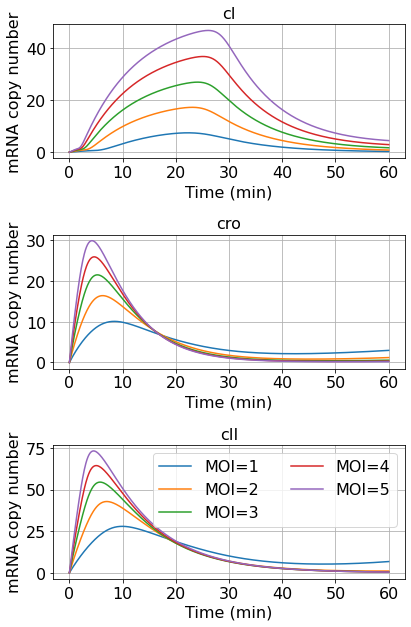

In [6]:
V = 1e-15; 
C = 1/6.02e23/V*1e9;
t = np.linspace(0, 60, 601);
Vt = V*np.exp(kd*t)
Ct = 1/6.02e23/Vt*1e9;
labels = ['cI', 'cro', 'cII']
plt.rcParams["figure.figsize"] = (6,9)
for j in range(0,3):
    subplot(3,1,j+1);
    for moi in np.arange(1,6,1):
        lamb0 = moi*C;
        y0 = [0,0,0,0,0,0,lamb0];
        sol0 = odeint(myfunc0, y0, t);
        plt.plot(t,sol0[:,j]/Ct,label='MOI='+str(moi))
    if j == 2:
        plt.legend(ncol=2)
    plt.xlabel('Time (min)')
    plt.ylabel('mRNA copy number')
    plt.title(labels[j])
    plt.grid()
plt.tight_layout()

### Fig. 2D

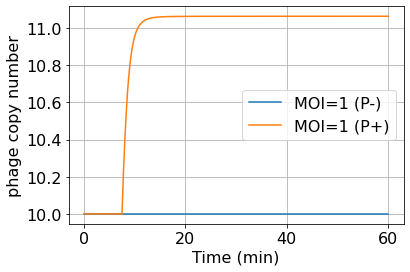

In [8]:
V = 1e-15; 
C = 1/6.02e23/V*1e9; 
t = np.linspace(0, 60, 601);
Vt = V*np.exp(kd*t)
Ct = 1/6.02e23/Vt*1e9;

labels = ['cI', 'cro', 'cII']
plt.rcParams["figure.figsize"] = (6,4)
moi = 10; 
lamb0 = moi*C;
y0 = [0,0,0,0,0,0,lamb0];
sol0 = odeint(myfunc0, y0, t);
sol1 = odeint(myfunc1, y0, t);

plt.plot(t,sol0[:,6]/Ct,label='MOI=1 (P-)')
plt.plot(t,sol1[:,6]/Ct,label='MOI=1 (P+)')
plt.xlabel('Time (min)')
plt.ylabel('phage copy number')
#plt.ylim((0,200))
plt.legend()
plt.grid()


### Fig. 3A, B

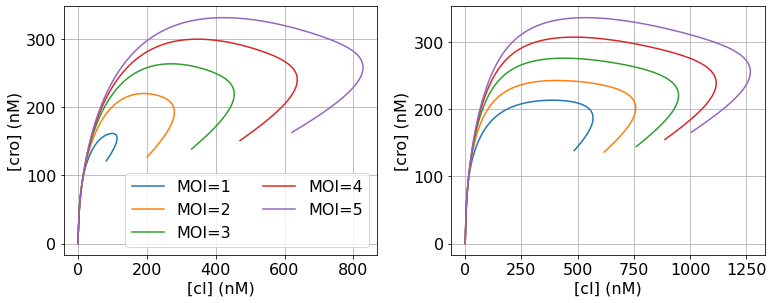

In [10]:
V = 1e-15; 
C = 1/6.02e23/V*1e9; 
t = np.linspace(0, 60, 601);

labels = ['cI', 'cro', 'cII']
plt.rcParams["figure.figsize"] = (11,4.5)
subplot(1,2,1)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc0, y0, t);
    cI = sol0[:,3];
    cro = sol0[:,4];
    plt.plot(cI,cro,label='MOI='+str(moi))
plt.xlabel('[cI] (nM)')
plt.ylabel('[cro] (nM)')
plt.legend(ncol=2)
plt.grid()

subplot(1,2,2)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    cI = sol0[:,3];
    cro = sol0[:,4];
    plt.plot(cI,cro,label='MOI='+str(moi))
plt.xlabel('[cI] (nM)')
plt.ylabel('[cro] (nM)')
#plt.legend(ncol=2)
plt.grid()

plt.tight_layout()

### Fig. 4A

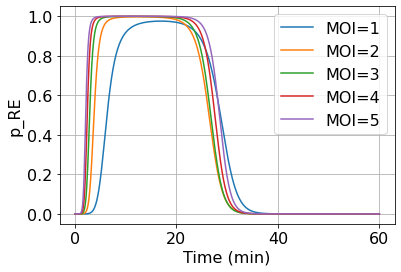

In [14]:
#f_cI_RE(cII)
plt.rcParams["figure.figsize"] = (6,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    cII = sol0[:,5];
    pRE = f_cI_RE(cII); 
    plt.plot(t,pRE,label='MOI='+str(moi))
    plt.legend(ncol=1)
plt.xlabel('Time (min)')
plt.ylabel('p_RE')
plt.grid()

### Fig. 4B

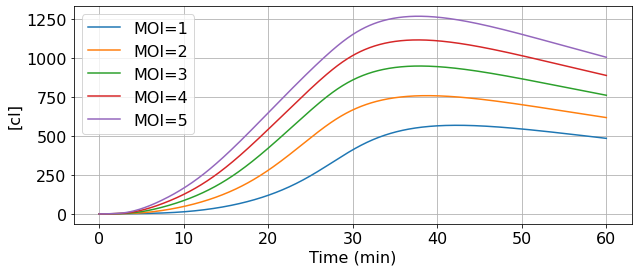

In [16]:
plt.rcParams["figure.figsize"] = (10,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    plt.plot(t,sol0[:,3],label='MOI='+str(moi))
    plt.legend(ncol=1)
plt.xlabel('Time (min)')
plt.ylabel('[cI]')
plt.grid()

### Fig. 4C Repression of cro by CI

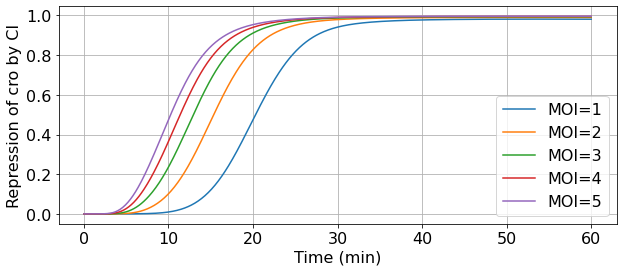

In [18]:
def f_repress_cro_by_cI(cI,cro): #cro transcription inhibition by cI and cro
    return np.power(cI/K_cro_cI,n_cro_cI)/(1+np.power(cI/K_cro_cI,n_cro_cI)+np.power(cro/K_cro_cro,n_cro_cro))

plt.rcParams["figure.figsize"] = (10,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    cI = sol0[:,3];
    cro = sol0[:,4];
    repress = f_repress_cro_by_cI(cI,cro); 
    plt.plot(t,repress,label='MOI='+str(moi))
    plt.legend(ncol=1)
plt.xlabel('Time (min)')
plt.ylabel('Repression of cro by CI')
plt.grid()

### Fig. 4D Repression of replication by CI

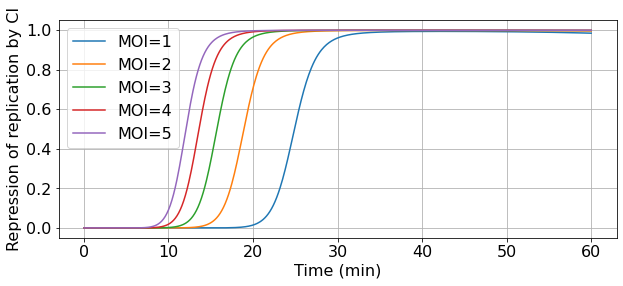

In [19]:
def f_repress_rep_by_cI(cI,cro): 
    return np.power(cI/K_lamb_cI,n_lamb_cI)/(1+np.power(cI/K_lamb_cI,n_lamb_cI)+np.power(cro/K_lamb_cro,n_lamb_cro))

plt.rcParams["figure.figsize"] = (10,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    cI = sol0[:,3];
    cro = sol0[:,4];
    repress = f_repress_rep_by_cI(cI,cro); 
    plt.plot(t,repress,label='MOI='+str(moi))
    plt.legend(ncol=1)
plt.xlabel('Time (min)')
plt.ylabel('Repression of replication by CI')
plt.grid()

### Fig. 6A, B

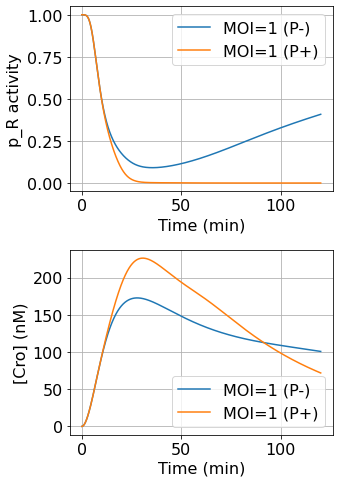

In [618]:
V = 1e-15; 
C = 1/6.02e23/V*1e9; 
t = np.linspace(0, 120, 60001);
klamb = 0.131; kd = 1/60;  #0.25

Vt = V*np.exp(kd*t)
Ct = 1/6.02e23/Vt*1e9;

#K_lamb_cI = 241; K_lamb_cro = 500;
K_lamb_cI = 900; K_lamb_cro = 500;
labels = ['cI', 'cro', 'cII']
plt.rcParams["figure.figsize"] = (5,7)
moi = 1; 
lamb0 = moi*C;
y0 = [0,0,0,0,0,0,lamb0];
sol0 = odeint(myfunc0, y0, t);
sol1 = odeint(myfunc1, y0, t);

subplot(2,1,1)
cI = sol0[:,3];
cro = sol0[:,4];
plt.plot(t,f_cro(cI,cro),label='MOI=1 (P-)')
cI = sol1[:,3];
cro = sol1[:,4];
plt.plot(t,f_cro(cI,cro),label='MOI=1 (P+)')
plt.xlabel('Time (min)')
plt.ylabel('p_R activity')
plt.legend()
plt.grid()

subplot(2,1,2)
plt.plot(t,sol0[:,4],label='MOI=1 (P-)')
plt.plot(t,sol1[:,4],label='MOI=1 (P+)')
plt.xlabel('Time (min)')
plt.ylabel('[Cro] (nM)')
plt.legend()
plt.grid()
plt.tight_layout()